In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl

2024-11-20 21:23:09.927503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import gymnasium as gym
import minigrid # Must import minigrid after gymnasium to register the environments properly.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
def generate_model_actor_classical_shared_mdp(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_MiniGrid_critic_classical_joint_pomdp_central(n_agents: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Reshape((n_agents,7,7,3))]
    layers += [keras.layers.Flatten()] # Flatten all inputs.
    layers += [keras.layers.Dense(u, activation=activation) for u in units] # Central branch dense layers.
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
import minigrid.wrappers

n_agents = 2
n_actions = 3 # 0=left, 1=right, 2=forward.
# env_id = "MiniGrid-LavaGapS5-v0"
env_id = "MiniGrid-Empty-5x5-v0"
# env_id = "MiniGrid-Empty-8x8-v0"
max_steps_per_episode = 50
env_vec = gym.vector.make(env_id, num_envs=n_agents, wrappers=[
    # minigrid.wrappers.ActionBonus,
    # minigrid.wrappers.PositionBonus,
    # minigrid.wrappers.FullyObsWrapper,
    minigrid.wrappers.ImgObsWrapper,
    eqmarl.wrappers.StepRewardWrapper,
    minigrid.wrappers.ActionBonus,
    # lambda env: minigrid.wrappers.NoDeath(env, no_death_types=('lava',), death_cost=-1.),
    # gym.RewardWrapper,
], render_mode="rgb_array", max_steps=max_steps_per_episode)
obs_shape = env_vec.observation_space.shape[1:]
obs_shape

2024-11-20 21:23:17.577810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 21:23:17.577928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(7, 7, 3)

In [6]:
# units = [12]
# units = [48, 24, 12]
# units = [32]
units = [100]
# learning_rate = 1.0e-3
# learning_rate = 1.0e-2 # Causes action probabilities to go to NaN.
learning_rate = 1.0e-4 
model_actor = generate_model_actor_classical_shared_mdp(
    n_actions=n_actions,
    units=units,
    name='fctde-actor',
)
model_actor.build([None, *obs_shape])
optimizer_actor = keras.optimizers.Adam(learning_rate=learning_rate)
model_critic = generate_model_MiniGrid_critic_classical_joint_pomdp_central(
    n_agents=n_agents,
    units=units,
    name='fctde-critic',
)
model_critic.build([None, n_agents, *obs_shape])
optimizer_critic = keras.optimizers.Adam(learning_rate=learning_rate)

model_actor.summary()
model_critic.summary()

Model: "fctde-actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 147)               0         
                                                                 
 dense (Dense)               (None, 100)               14800     
                                                                 
 policy (Dense)              (None, 3)                 303       
                                                                 
Total params: 15,103
Trainable params: 15,103
Non-trainable params: 0
_________________________________________________________________
Model: "fctde-critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 7, 7, 3)        0         
                                                                 
 flatten_1 (Flatten)         

In [7]:
algo = eqmarl.algorithms.MAA2C(
    env=env_vec,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=0.99,
    # gamma=0.95,
    alpha=0.001,
    # alpha=0.01,
    # alpha=0.1,
    # epsilon=0.1,
    # epsilon=0.3,
    # epsilon=0.4,
    )

In [8]:
n_episodes = 1000
reward_history, metrics_history = algo.train(
    n_episodes=n_episodes,
    max_steps_per_episode=max_steps_per_episode,
)

Training for 1000 episodes, press 'Ctrl+C' to terminate early
Episode 1000: 100%|██████████| 1000/1000 [02:28<00:00,  6.76episode/s, episode_reward=[-23.67890125  57.07848095]]


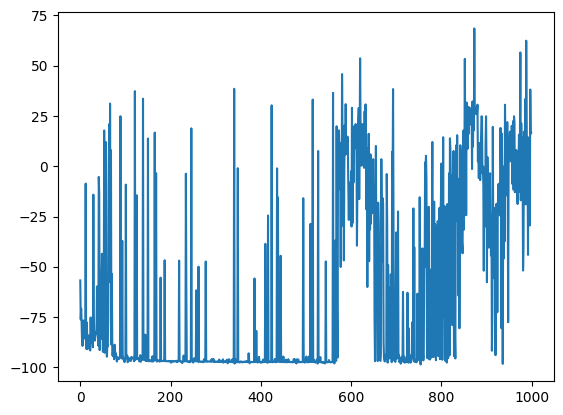

In [9]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.plot(x, y)

In [10]:
np.savetxt("minigrid-fctde-rewards.csv", reward_history, delimiter=',')

In [28]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate(imgs: list, type='js', title=None): # 'js' or 'html'

    # Create figure and axes
    fig, ax = plt.subplots()
    if title:
        fig.suptitle(title)

    def _animate(i):
        ax.clear()
        ax.imshow(imgs[i])
        ax.set_title(f"step {i}")

    anim = animation.FuncAnimation(fig, _animate, frames=len(imgs), interval=200)

    # Convert the animation to HTML5 video
    # HTML(anim.to_html5_video())
    if type == 'js':
        return HTML(anim.to_jshtml())
    else:
        # return HTML(anim.to_html5_video())
        return anim.to_html5_video()

In [12]:
def run(env, model_actor):
    actions = []
    rewards = []
    imgs = []
    # obs, info = env.reset(seed=42)
    s, info = env.reset()
    imgs.append(env.render())
    for t in range(max_steps_per_episode):
        s = tf.convert_to_tensor(s)
        s = tf.reshape(s, (-1, *s.shape))
        # print(f"{s.shape=}")

        action_probs = model_actor(s)
        
        # Sample action from estimated probability distribution.
        action = np.random.choice(action_probs.shape[-1], p=np.squeeze(action_probs))
        
        s, reward, terminated, truncated, info  = env.step(action)
        actions.append(action)
        rewards.append(reward)
        
        img = env.render()
        imgs.append(img)
        
        # print(f"{t=}, {reward=}, {action=}, {terminated=}")
        
        if terminated:
            break
    return imgs, actions, rewards

In [13]:
env = gym.make(env_id, render_mode="rgb_array")
env = minigrid.wrappers.ImgObsWrapper(env)
imgs, _, _ = run(env, model_actor)
print(f"{len(imgs)-1} steps")

17 steps


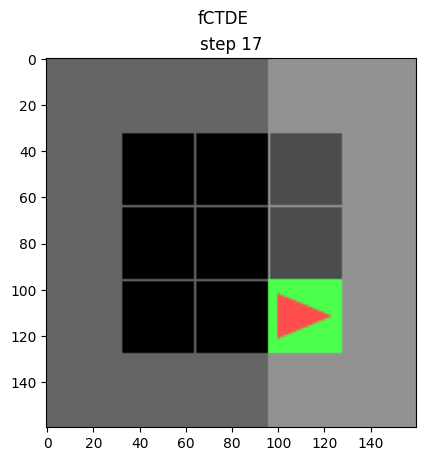

In [26]:
animate(imgs, type='js', title='fCTDE')

'<video width="640" height="480" controls autoplay loop>\n  <source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAN8BtZGF0AAACrgYF//+q\n3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF\nRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u\nb3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs\neXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk\nX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk\nZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1\nIGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50\nZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi\nX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w\nPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj01IHNjZW5lY3V0PTQwIGludHJhX3Jl\nZnJlc2g9MCByY19sb29rYWhlYWQ9ND

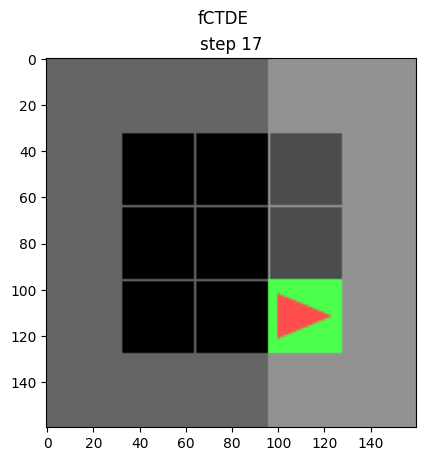

In [29]:
animate(imgs, type='html', title='fCTDE')

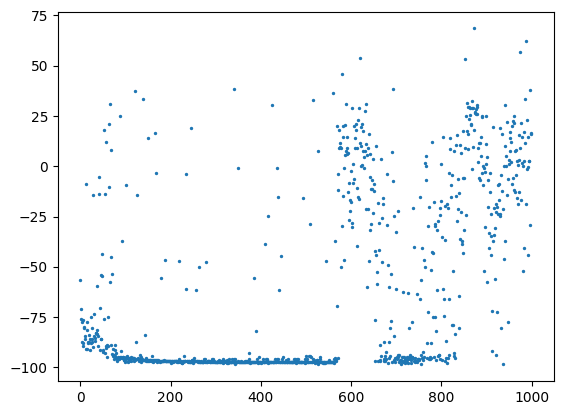

In [24]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.scatter(x, y, s=2)